🎧 **İçerik Bazlı Müzik Öneri Sistemi**

📌 **Problem Tanımı**

Kullanıcıların dinleme alışkanlıklarına veya seçtikleri bir şarkının içerik özelliklerine (örneğin: *danceability, tempo, energy, valence, loudness* vb.) dayanarak yeni şarkılar öneren bir **Content-Based Filtering (İçerik Bazlı Filtreleme)** sistemi geliştirilmesi hedeflenmektedir.

Bu sistem, kullanıcı tarafından seçilen bir şarkının özelliklerini analiz ederek, veri kümesindeki diğer şarkılarla benzerlik ölçümü yapar ve en yakın şarkıları önerir.

🎯 **Hedef**

Kullanıcının sevdiği veya seçtiği bir şarkıya içerik bakımından en çok benzeyen şarkıları belirlemek ve kullanıcıya kişiselleştirilmiş bir öneri listesi sunmak.

**KULLANACAĞIMIZ KÜTÜPHANELER VE DİĞER AYARLAR**

In [2]:
# Kullanacağımız Kütüphaneleri yükledik ve Diğer Ayarlamaları yaptık
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Uyarıları kapatalım, temiz görünsün
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.max_columns', None)

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


In [4]:
# Verimizi yükledik.

df = pd.read_csv('../data/Spotify_dataset.csv')

print(f"Veri Seti Boyutu: {df.shape}")

Veri Seti Boyutu: (114000, 21)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [6]:
# İlk 5 satıra bakalım
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [7]:
# Track ID'ye göre Kayıt Kontrolü 
if 'track_id' in df.columns:
    duplicates = df.duplicated(subset=['track_id']).sum()
    print(f"Tekrar eden şarkı sayısı (track_id): {duplicates}")
else:
    duplicates = df.duplicated().sum()
    print(f"Tamamen tekrar eden satır sayısı: {duplicates}")

Tekrar eden şarkı sayısı (track_id): 24259


In [8]:
# 2. Eksik Değer Kontrolü
print("\nEksik Değerler (Null Values):")
print(df.isnull().sum()[df.isnull().sum() > 0])


Eksik Değerler (Null Values):
artists       1
album_name    1
track_name    1
dtype: int64


In [9]:
# Spotify API'sinden gelen tipik ses özellikleri
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Veri setinde bu kolonlardan hangileri var kontrol et
existing_features = [col for col in audio_features if col in df.columns]

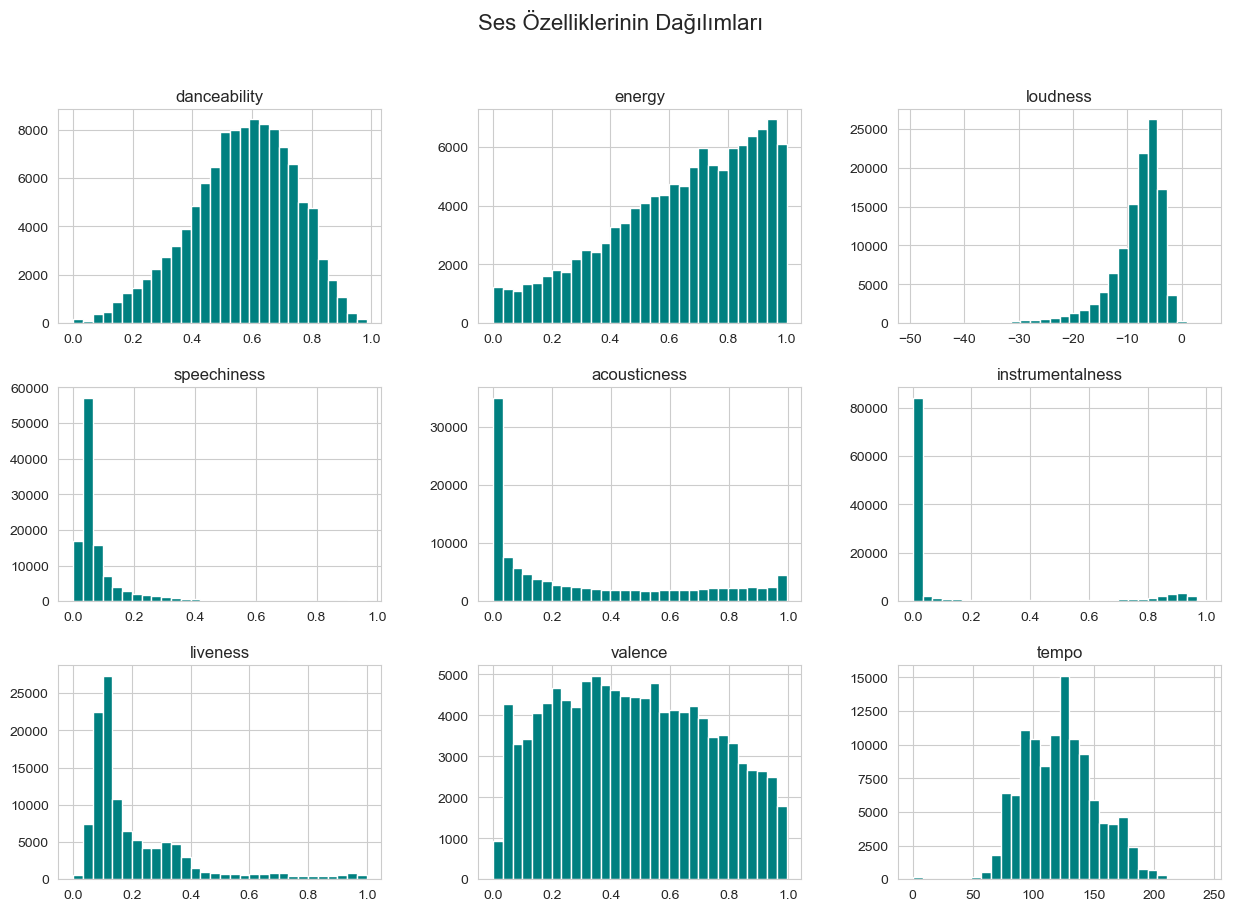

In [10]:
# Histogramları çizdir
df[existing_features].hist(bins=30, figsize=(15, 10), layout=(3, 3), color='teal')
plt.suptitle('Ses Özelliklerinin Dağılımları', fontsize=16)
plt.show()

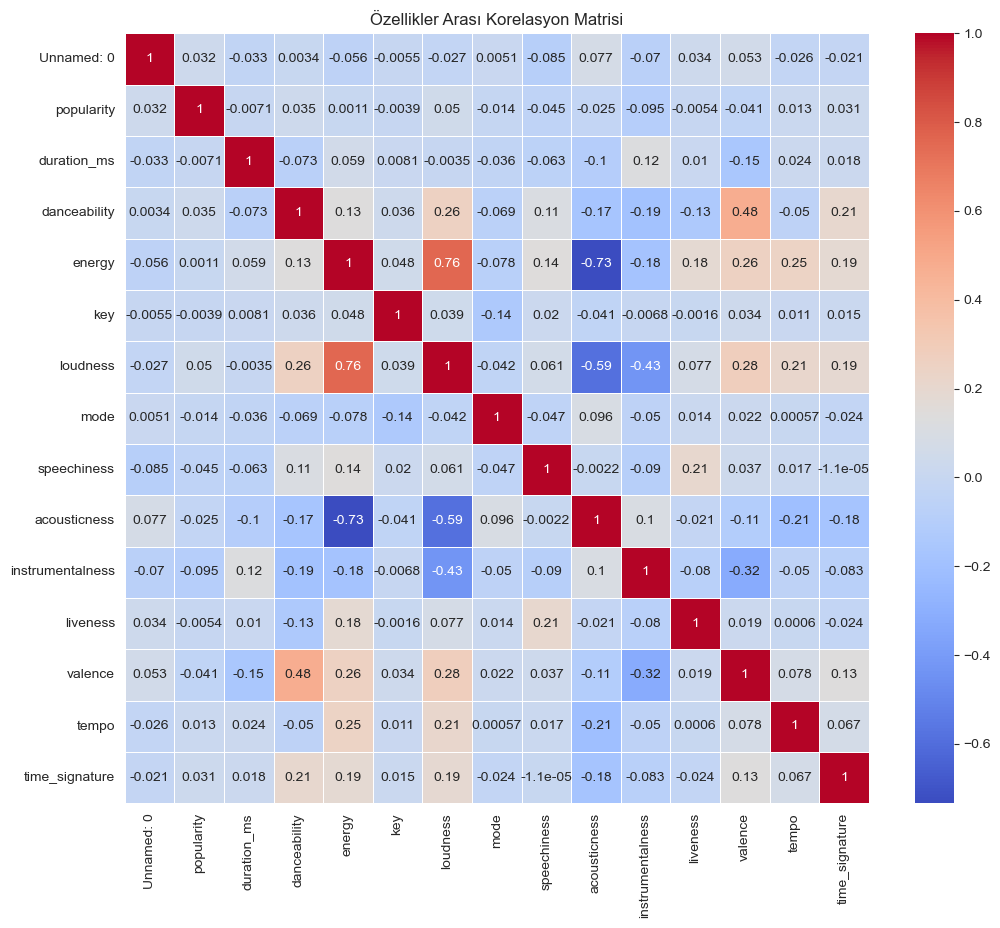

In [13]:
plt.figure(figsize=(12, 10))
# Sadece sayısal kolonları al
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Heatmap çiz
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.show()

In [14]:
# En yüksek korelasyonları listeleyelim
# (Self-correlation olan 1.0'ları filtrelemek için basit bir trick)
corr_unstack = correlation_matrix.unstack()
sorted_corr = corr_unstack.sort_values(kind="quicksort", ascending=False)
print("En Yüksek Pozitif Korelasyonlar:\n", sorted_corr[sorted_corr < 1.0].head(5))

En Yüksek Pozitif Korelasyonlar:
 energy        loudness        0.761690
loudness      energy          0.761690
valence       danceability    0.477341
danceability  valence         0.477341
valence       loudness        0.279848
dtype: float64


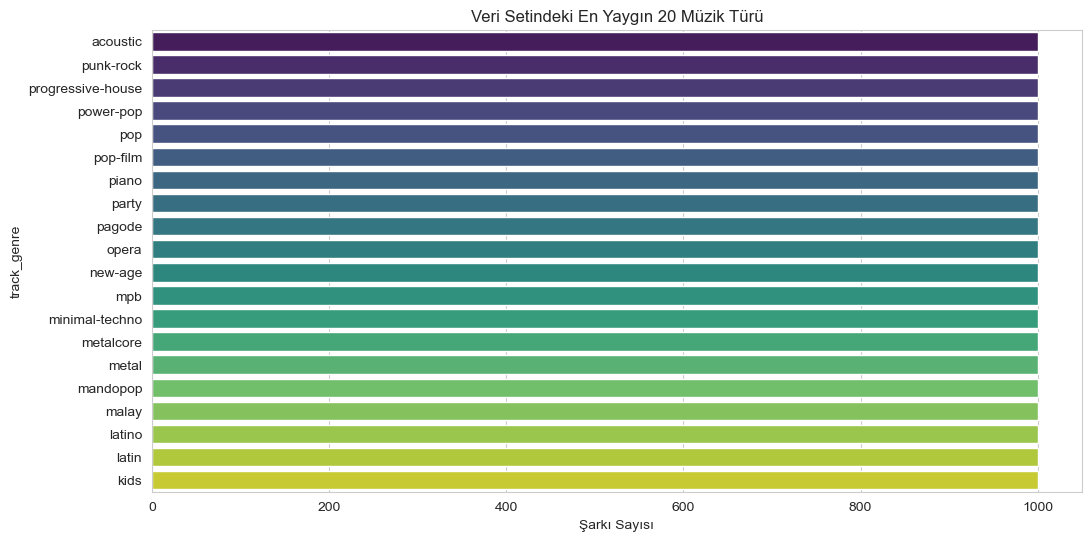

In [15]:
# Kolon adı 'track_genre' veya 'genre' olabilir, kontrol et
genre_col = 'track_genre' if 'track_genre' in df.columns else 'genre'

if genre_col in df.columns:
    plt.figure(figsize=(12, 6))
    top_genres = df[genre_col].value_counts().head(20)
    sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
    plt.title('Veri Setindeki En Yaygın 20 Müzik Türü')
    plt.xlabel('Şarkı Sayısı')
    plt.show()

## EDA Bulguları ve Sonuçlar

1. **Veri Yapısı:** Veri setimiz 114000 satır ve 21 kolondan oluşuyor. 'track_id' kolonunda 24259 adet tekrar eden kayıt tespit edildi, bunlar temizlik aşamasında silinecek.
2. **Ses Özellikleri:** - 'Loudness' ve 'Energy' arasında güçlü bir pozitif korelasyon var (0.76). Modelde ikisini birden kullanmak "multicollinearity" yaratabilir, biri elenebilir.
   - 'Instrumentalness' verisinin çoğu 0 noktasında toplanmış, bu da veri setinin çoğunun sözlü müzik olduğunu gösteriyor.
3. **Tür Dağılımı:** Veri seti dengeli/dengesiz bir tür dağılımına sahip. En çok bulunan tür: Acoustic. 